In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.feature_selection import RFECV

from encoders import BinaryEncoder, DaysSinceEncoder, PercentToNumberEncoder, AmenitiesEncoder
#from encoders import ColumnDropper

sns.set()

In [81]:
df = pd.read_csv('data/train.csv')
df = df[df['log_price'] > 0]
df.head()

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,...,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,...,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0
2,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,...,40.808110,-73.943756,The Garden Oasis,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0
3,13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,...,37.772004,-122.431619,Beautiful Flat in the Heart of SF!,Lower Haight,0,NaN,https://a0.muscache.com/im/pictures/72208dad-9...,94117.0,2.0,2.0
4,3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,...,38.925627,-77.034596,Great studio in midtown DC,Columbia Heights,4,40.0,NaN,20009,0.0,1.0


In [9]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=710)

X_train = train_df.drop(columns=['log_price'])
y_train = train_df['log_price']

X_test = test_df.drop(columns=['log_price'])
y_test = test_df['log_price']

In [10]:
numeric_cols = ['accommodates', 'bathrooms', 'number_of_reviews', 'review_scores_rating', 'bedrooms', 'beds']
onehot_cols = ['property_type', 'room_type', 'bed_type', 'city', 'cleaning_fee']
ordinal_cols = ['cancellation_policy']
binary_cols = ['host_has_profile_pic', 'host_identity_verified', 'instant_bookable']
date_cols = ['first_review', 'host_since', 'last_review']
percent_cols = ['host_response_rate']
amenities_cols = ['amenities']
drop_cols = ['id', 'description', 'latitude', 'longitude', 'name', 'neighbourhood', 'thumbnail_url', 'zipcode'] #usunąć potem zipcoda

In [11]:
numeric_pipe = Pipeline(steps=[
    ('impute', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('scale', StandardScaler())
])

binary_pipe = Pipeline(steps=[
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='f')),
    ('encode', BinaryEncoder())
])

percent_pipe = Pipeline(steps=[
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)),
    ('encode', PercentToNumberEncoder())
])

column_transformer = ColumnTransformer(
    [('numeric', numeric_pipe, numeric_cols),
     ('onehot', OneHotEncoder(handle_unknown='ignore'), onehot_cols),
     ('ordinal', OrdinalEncoder(categories=[['flexible', 'moderate', 'strict', 'super_strict_30', 'super_strict_60']]), ordinal_cols),
     ('binary', binary_pipe, binary_cols),
     ('date', DaysSinceEncoder(), date_cols), # missing values are handled inside encoder
     ('precent', percent_pipe, percent_cols),
     ('amenities', AmenitiesEncoder(), amenities_cols)],
    remainder='drop'
    #  ('dropper', ColumnDropper(columns=drop_cols), drop_cols)],
    # remainder='passthrough'
)

In [72]:
X_train_.shape

(59288, 65)

In [73]:
X_test_.shape

(14823, 65)

In [71]:
X_train_ = pd.DataFrame(column_transformer.fit_transform(X_train))
X_test_ = pd.DataFrame(column_transformer.transform(X_test))

In [ ]:
import sklearn
import warnings

In [ ]:
def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == sklearn.pipeline.Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == sklearn.pipeline.Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names


In [ ]:
X_train_.columns = get_feature_names(column_transformer)
X_test_.columns = X_train_.columns

In [15]:
import xgboost
import shap

In [70]:
def feature_engineering(model, X_train, X_test):
    shap_values = shap.TreeExplainer(model).shap_values(X_train)
    shap.summary_plot(shap_values, X_train, plot_type="bar", max_display=X_train.shape[1], show=False)
    plt.title("Feature importances based on shap value")
    plt.show()
    
    lista = []
    for i in range(X_train.shape[1]):
        col_sum = 0
        for j in range(X_train.shape[0]):
            col_sum += abs(shap_values[j][i])
        lista.append(col_sum/(X_train.shape[0] + 1))
    
    
    indexy = []
    for i in range(X_train.shape[1]):
        if(lista[i] <= 0.01):
            indexy.append(i)
    
    X_train.drop(X_train.columns[indexy], axis = 1, inplace = True)
    X_test.drop(X_test.columns[indexy], axis = 1, inplace = True)

In [17]:
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error

In [33]:
xgb = xgboost.XGBRegressor(eval_metric = "merror")

In [28]:
rfr = RandomForestRegressor(max_depth = 6)

In [35]:
xgb.fit(X_train_, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             eval_metric='merror', gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [29]:
rfr.fit(X_train_, y_train)

RandomForestRegressor(max_depth=6)

In [30]:
pred_train = rfr.predict(X_train_)

In [31]:
pred_test = rfr.predict(X_test_)

In [68]:
print("RMSE dla treningowego: " + str(mean_squared_error(y_train, pred_train)))
print("RMSE dla testowego: " + str(mean_squared_error(y_test, pred_test)))

RMSE dla treningowego: 0.16163681517275777
RMSE dla testowego: 0.1994137920554514


In [36]:
pred_train = xgb.predict(X_train_)

In [37]:
pred_test = xgb.predict(X_test_)

In [38]:
print("RMSE dla treningowego: " + str(mean_squared_error(y_train, pred_train)))
print("RMSE dla testowego: " + str(mean_squared_error(y_test, pred_test)))

RMSE dla treningowego: 0.15602038840601154
RMSE dla testowego: 0.19036035484427857


In [75]:
X_train_

,0,1,2,3,4,23,40,41,49,50,51,52,53,56,60,61,62,63,64
0,-0.535818,-0.403677,-0.498178,8.615390e-01,-0.311447,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1886.0,2768.0,1882.0,0.0,1.0
1,-0.535818,-0.403677,0.397210,7.165768e-01,-1.483394,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2042.0,2458.0,1832.0,100.0,0.0
2,-0.535818,-0.403677,2.293326,1.367279e-01,-0.311447,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2816.0,3363.0,1682.0,100.0,1.0
3,-0.535818,-0.403677,1.634952,-2.981588e-01,-0.311447,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,2606.0,3534.0,1697.0,100.0,1.0
4,-0.071543,-0.403677,-0.366503,8.615390e-01,-1.483394,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,2099.0,2110.0,1930.0,100.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59283,-0.535818,-0.403677,-0.550848,2.060037e-15,-1.483394,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.0,4474.0,-1.0,0.0,0.0
59284,-0.535818,-0.403677,-0.340168,5.716146e-01,-0.311447,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,2131.0,2410.0,2105.0,0.0,0.0
59285,-1.000094,1.312855,0.397210,2.816901e-01,-0.311447,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2064.0,2973.0,1838.0,100.0,1.0
59286,-0.535818,-0.403677,-0.471843,8.615390e-01,-0.311447,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,1802.0,2050.0,1680.0,100.0,0.0


In [76]:
xgb_fs = xgboost.XGBRegressor(eval_metric = "merror")

In [77]:
xgb_fs.fit(X_train_, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             eval_metric='merror', gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [78]:
pred_train = xgb_fs.predict(X_train_)

In [79]:
pred_test = xgb_fs.predict(X_test_)

In [80]:
print("RMSE dla treningowego: " + str(mean_squared_error(y_train, pred_train)))
print("RMSE dla testowego: " + str(mean_squared_error(y_test, pred_test)))

RMSE dla treningowego: 0.15696659128211865
RMSE dla testowego: 0.19363447692378463


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


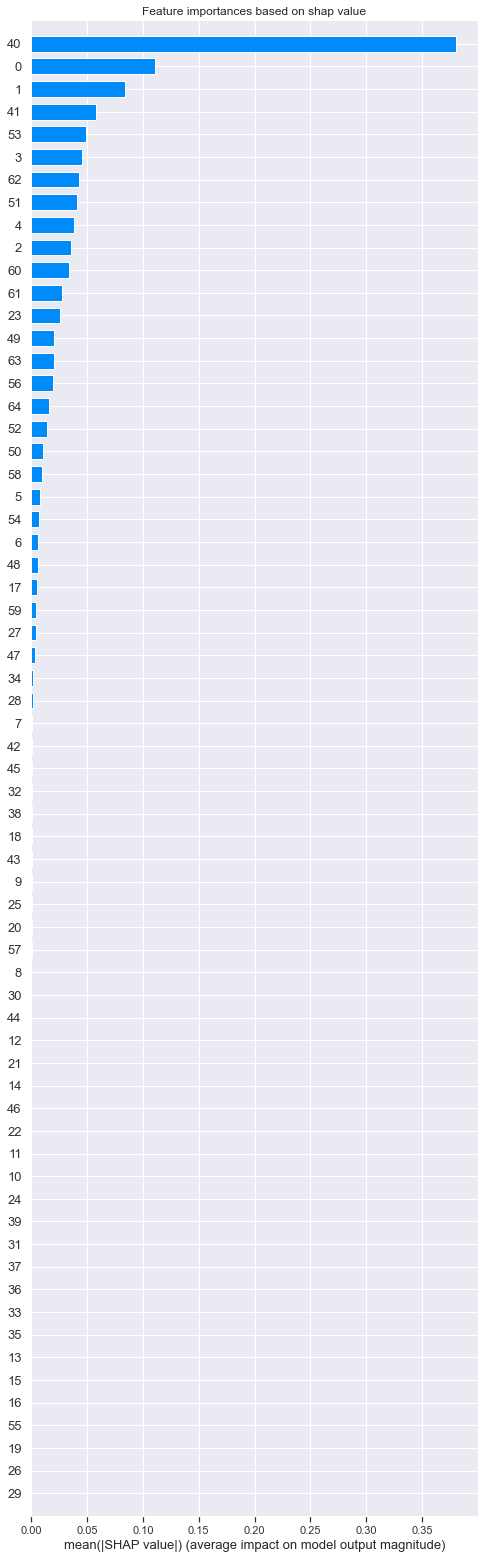

In [74]:
feature_engineering(xgb, X_train_, X_test_)